In [1]:
pip install causalgraphicalmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from causalgraphicalmodels import StructuralCausalModel
from causalgraphicalmodels.csm import discrete_model, linear_model

from sklearn.linear_model import LinearRegression
import math

# Continuous model

Generating the model

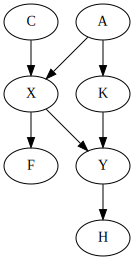

In [3]:
fd_cont = StructuralCausalModel({
    "C": lambda n_samples: np.random.uniform(low=-10, high=10,
                                             size=n_samples),
    "A": lambda n_samples: .8 * np.random.normal(size=n_samples),
    "K": lambda A, n_samples: A + .1 * np.random.normal(),
    "X": lambda C, A, n_samples: 0.7 * C - 2 * A + .2 * np.random.normal(),
    "F": lambda X, n_samples: 3 * X + .8 * np.random.normal(),
    "Y": lambda K, X, n_samples: 2 * K - X + .2 * np.random.normal(),
    "H": lambda Y, n_samples: .5 * Y + .1 * np.random.normal()
})

fd_cont.cgm.draw()

In [4]:
data_df = fd_cont.sample(n_samples=1000000)

In [5]:
data_df

,C,A,K,X,F,Y,H
0,-7.446542,-0.351285,-0.064914,-4.843396,-14.025900,4.592544,2.348986
1,-5.850157,0.179307,0.465678,-4.787111,-13.857044,5.597443,2.851436
2,7.064538,-0.500316,-0.213945,5.612422,17.341555,-6.161336,-3.027954
3,2.680662,-0.474781,-0.188411,2.492640,7.982209,-2.990486,-1.442528
4,3.712003,0.529681,0.816052,1.205654,4.121250,0.305426,0.205427
...,...,...,...,...,...,...,...
999995,-1.745480,0.434419,0.720790,-2.424060,-6.767891,3.744615,1.925022
999996,-7.438842,-0.665124,-0.378754,-4.210327,-12.126692,3.331795,1.718612
999997,4.645469,-1.025749,-0.739378,4.969941,15.414110,-6.569722,-3.232146
999998,4.917519,-0.608781,-0.322410,4.326439,13.483605,-5.092283,-2.493427


Excercise 1:

Implement backdoor adjustment for arbitrary treatment, effect and conditioning set using Linear Regression.

Check if your implementation is working correctly.

In [6]:
all_sets = [
            ['C'],
            ['A'],
            ['K'],
            ['F'],
            ['H'],
            ['C', 'A'],
            ['C', 'K'],
            ['C', 'F'],
            ['C', 'H'],
            ['A', 'K'],
            ['A', 'F'],
            ['A', 'H'],
            ['K', 'F'],
            ['K', 'H'],
            ['F', 'H'],
            ['C', 'A', 'K'],
            ['C', 'A', 'F'],
            ['C', 'A', 'H'],
            ['C', 'K', 'F'],
            ['C', 'K', 'H'],
            ['C', 'F', 'H'],
            ['A', 'K', 'F'],
            ['A', 'K', 'H'],
            ['K', 'F', 'H'],
            ['C', 'A', 'K', 'F'],
            ['C', 'A', 'K', 'H'],
            ['C', 'K', 'F', 'H'],
            ['A', 'K', 'F', 'H'],
            ['C', 'A', 'K', 'F', 'H']
            ]

In [7]:
def my_backdoor_adjustment_regression(data=data_df, T='X', Y='Y', cond_set = ['A', 'K'], true_ate=None):
    # add your implementation
    # conditioning set can be empty, can contain 1 or more variables.
    # conditioning set never contains T or Y
    regressor = LinearRegression()
    regressor.fit(data[list(T) + cond_set].values, data[Y].values)  
    print(f"Set: {list(T) + cond_set}, X has the coefficient: {regressor.coef_[0]}")
    coeff_X = regressor.coef_[0]
    if math.isclose(coeff_X, true_ate, rel_tol=1e-2) == True:
      return True
    else:
      return False   
        

In [8]:
adj_sets = []
for var_set in all_sets:
  if my_backdoor_adjustment_regression(data_df, T='X', Y='Y', cond_set=var_set, true_ate = -1) == True:
    adj_sets.append(var_set)

Set: ['X', 'C'], X has the coefficient: -1.999999999999998
Set: ['X', 'A'], X has the coefficient: -0.9999999999999996
Set: ['X', 'K'], X has the coefficient: -0.9999999999999996
Set: ['X', 'F'], X has the coefficient: -0.11354609414424445
Set: ['X', 'H'], X has the coefficient: -9.593853773947124e-16
Set: ['X', 'C', 'A'], X has the coefficient: -0.20375736572873518
Set: ['X', 'C', 'K'], X has the coefficient: -0.1997763547371682
Set: ['X', 'C', 'F'], X has the coefficient: -0.19999999999999987
Set: ['X', 'C', 'H'], X has the coefficient: 0.23340024165133336
Set: ['X', 'A', 'K'], X has the coefficient: -0.9999999999999994
Set: ['X', 'A', 'F'], X has the coefficient: -0.10000000000000006
Set: ['X', 'A', 'H'], X has the coefficient: -0.44444444444444486
Set: ['X', 'K', 'F'], X has the coefficient: -0.10000000000000006
Set: ['X', 'K', 'H'], X has the coefficient: -0.444444444444445
Set: ['X', 'F', 'H'], X has the coefficient: -3.3963743319143456e-17
Set: ['X', 'C', 'A', 'K'], X has the co

In [9]:
adj_sets


[['A'], ['K'], ['A', 'K']]

Valid adjustments sets:

In [10]:
fd_cont.cgm.get_all_backdoor_adjustment_sets(x='X', y='Y')

frozenset({frozenset({'A'}),
           frozenset({'A', 'C'}),
           frozenset({'K'}),
           frozenset({'C', 'K'}),
           frozenset({'A', 'K'}),
           frozenset({'A', 'C', 'K'})})

We notice that from the sets that adjustment sets (obtained by `get_all_backdoor_adjustment_sets`), those containing the random variable $C$ is missing fomr the sets contained in `adj_sets`.

This is due to the choice of linear regression as method of estimation. Choosing the right model would overcome this issue.



# Discrete model


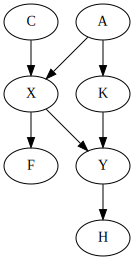

In [11]:
fd_disc = StructuralCausalModel({
    "C": lambda n_samples: np.random.binomial(n=1, p=0.7, size=n_samples),
    "A": lambda n_samples: np.random.binomial(n=1, p=0.2, size=n_samples),
    "K": lambda A, n_samples: A + .1 * np.random.normal(),
    "K": discrete_model(["A"], {
        (0, ): (0.9, 0.1),
        (1, ): (0.3, 0.7),
        }),
    "X": discrete_model(["C", "A"], {
        (0, 0): (0.1, 0.9), 
        (0, 1): (0.7, 0.3),
        (1, 0): (0.5, 0.5),
        (1, 1): (0.8, 0.2),
        }),  
    "F": discrete_model(["X"], {
        (0, ): (0.6, 0.4),
        (1, ): (0.1, 0.9),
        }),
    "Y": discrete_model(["K", "X"], {
        (0, 0): (0.9, 0.1), 
        (0, 1): (0.3, 0.7),
        (1, 0): (0.2, 0.5),
        (1, 1): (0.5, 0.5),
        }),
    "H": discrete_model(["Y"], {
        (0, ): (0.2, 0.4, 0.4),
        (1, ): (0.8, 0.1, 0.1),
        }),
})

fd_disc.cgm.draw()

In [12]:
data_disc = fd_disc.sample(n_samples = 1000000)
data_disc.head()

,C,A,K,X,F,Y,H
0,1,0,0.0,1.0,1.0,1.0,0.0
1,1,0,0.0,0.0,0.0,0.0,1.0
2,1,1,1.0,0.0,0.0,0.0,1.0
3,1,0,0.0,0.0,0.0,0.0,1.0
4,1,0,0.0,1.0,1.0,1.0,0.0


In [13]:
data_disc.describe()

,C,A,K,X,F,Y,H
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,0.699881,0.200796,0.220324,0.542114,0.671168,0.494810,0.755392
std,0.458310,0.400596,0.414465,0.498224,0.469789,0.499973,0.829747
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
75%,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


Identifying True causal effect:

In [14]:
set_variable_X = np.array([0]*500000 + [1]*500000)
ab_test_df = fd_disc.do('X').sample(
                    set_values={'X': set_variable_X}, 
                    n_samples=len(set_variable_X),
                  )
ab_test_df.head()

,C,A,X,K,F,Y,H
0,1,0,0,0.0,0.0,0.0,1.0
1,1,0,0,0.0,0.0,0.0,0.0
2,1,1,0,0.0,0.0,0.0,0.0
3,1,0,0,0.0,0.0,0.0,0.0
4,1,0,0,0.0,0.0,0.0,1.0


In [15]:
true_ate = ab_test_df[ab_test_df['X'] == 1]['Y'].mean() - ab_test_df[ab_test_df['X'] == 0]['Y'].mean()
true_ate

0.420394

Excercise 2:

1. Can we estimate causal effect for discrete model using regression? Try using the function you implemented above.
2. Test all possible adjustment sets. Are there any additional adjustments sets with correct result?

Valid backdoor adjustment sets

In [16]:
fd_disc.cgm.get_all_backdoor_adjustment_sets(x='X', y='Y')

frozenset({frozenset({'A'}),
           frozenset({'A', 'C'}),
           frozenset({'K'}),
           frozenset({'C', 'K'}),
           frozenset({'A', 'K'}),
           frozenset({'A', 'C', 'K'})})

In [17]:
adj_sets = []
for var_set in all_sets:
  if my_backdoor_adjustment_regression(data_disc, T='X', Y='Y', cond_set=var_set, true_ate = true_ate) == True:
    adj_sets.append(var_set)

Set: ['X', 'C'], X has the coefficient: 0.373721906988492
Set: ['X', 'A'], X has the coefficient: 0.4416813456249159
Set: ['X', 'K'], X has the coefficient: 0.4263010886581491
Set: ['X', 'F'], X has the coefficient: 0.387000669146451
Set: ['X', 'H'], X has the coefficient: 0.2840398567410241
Set: ['X', 'C', 'A'], X has the coefficient: 0.43553315275660426
Set: ['X', 'C', 'K'], X has the coefficient: 0.41881639314383573
Set: ['X', 'C', 'F'], X has the coefficient: 0.3753075217898383
Set: ['X', 'C', 'H'], X has the coefficient: 0.27551770434801015
Set: ['X', 'A', 'K'], X has the coefficient: 0.4416271332366556
Set: ['X', 'A', 'F'], X has the coefficient: 0.4430836204475926
Set: ['X', 'A', 'H'], X has the coefficient: 0.32836406273389546
Set: ['X', 'K', 'F'], X has the coefficient: 0.4276520520799419
Set: ['X', 'K', 'H'], X has the coefficient: 0.31900825500917174
Set: ['X', 'F', 'H'], X has the coefficient: 0.2852713737571327
Set: ['X', 'C', 'A', 'K'], X has the coefficient: 0.4354319915

In [18]:
adj_sets

[['C', 'K'], ['C', 'K', 'F']]

Excercise 3:

1. Implement backdoor adjustment for arbitrary treatment, effect and conditioning set using ATE formula.

Hint: you can use dummy variable to split your dataset according to all possible combinations of confounders.

Check if your implementation is working correctly.

2. Test all possible adjustment sets. Are there any additional adjustments sets with correct result?

In [36]:
def my_backdoor_adjustment_descrete(data=data_disc, T='X', Y='Y', cond_set = ['A', 'K'], true_ate=None):
    # add your implementation
    # conditioning set can be empty, can contain 1 or more variables.
    # conditioning set never contains T or Y
    
    variable_values = []
    n = len(cond_set)
    ## list of lists that inner list (i) contain all values of ith variable in cond_set
    variable_values = [data[cond_set[i]].unique().astype(int).tolist() for i in range(n)]
    ## convert every value to character
    variable_values_char = [list(map(str, variable)) for variable in variable_values]
    import itertools
    ## construct all possible combination of values for variables of cond_set
    combinations = list(itertools.product(*variable_values_char ))
    ## now using the combinations we construct all possible queries within the data (dataframe)
    queries = []
    for i in range(len(combinations)):
      query_string = ''
      for j in range(n):
        query_string += f'{cond_set[j]} == {combinations[i][j]} and '
        if j == n-1:
          queries.append(query_string[:-5])
    ## example of an element in the queries list: 'A == 0 and K == 0'      
    ATE = 0
    ## Obtain possible values of X
    X_values = data[T].unique().astype(int).tolist()
    ATE_terms = []
    counter = 0
    for x in X_values:
      ATE_terms.append(0)
      for q in queries:
        ## Add current value of x to the query q (q is obtained from list of all possible queries, over which we are iterating)
        ## example of q: ""
        nq = f'{T} == {x} and ' + q
        ## Probability of the event q occurring
        size = data.query(q).shape[0] / data.shape[0]
        ## Calucate expectation of Y based on the query new query (nq) that adds current values of x to the query
        E_Y = data.query(nq)[Y].mean()
        ## Calculate E_Y conditioned on nq (query q + value of x)
        ## the condition has all values of the confounders and also the value of x
        ATE_terms[counter] += size * E_Y
      counter += 1;
    ## Since X (treatment) has 2 values, the following quantity would be just ATE[1] - ATE[0]
    #ATE = ATE_terms[-1] - sum(ATE_terms[:-1])  
    ATE = ATE_terms[0] - ATE_terms[1]
    #print(ATE, true_ate)
    print(f"ATE for set {cond_set}: {ATE}")
    if math.isclose(ATE, true_ate, rel_tol=1e-2) == True:
      return True
    else:
      return False    

In [37]:
my_backdoor_adjustment_descrete(data=data_disc, T='X', Y='Y', cond_set = ['A', 'K'], true_ate=true_ate)

ATE for set ['A', 'K']: 0.42146706376963033


True

In [38]:
true_ate

0.420394

In [39]:
adj_sets = []
for var_set in all_sets:
  if my_backdoor_adjustment_descrete(data_disc, T='X', Y='Y', cond_set=var_set, true_ate = true_ate) == True:
    adj_sets.append(var_set)

ATE for set ['C']: 0.36475260487206757
ATE for set ['A']: 0.4213734632009075
ATE for set ['K']: 0.42149392556182924
ATE for set ['F']: 0.38705453889924996
ATE for set ['H']: 0.2610150697784404
ATE for set ['C', 'A']: 0.421681304998894
ATE for set ['C', 'K']: 0.42159104565570343
ATE for set ['C', 'F']: 0.36667067244536655
ATE for set ['C', 'H']: 0.2455315523026559
ATE for set ['A', 'K']: 0.42146706376963033
ATE for set ['A', 'F']: 0.42217179827483264
ATE for set ['A', 'H']: 0.3068833046033048
ATE for set ['K', 'F']: 0.4223946441184531
ATE for set ['K', 'H']: 0.3291619506559544
ATE for set ['F', 'H']: 0.26195440013684573
ATE for set ['C', 'A', 'K']: 0.4216025370679053
ATE for set ['C', 'A', 'F']: 0.4222933340824452
ATE for set ['C', 'A', 'H']: 0.3076629554746585
ATE for set ['C', 'K', 'F']: 0.42263151707208446
ATE for set ['C', 'K', 'H']: 0.32962757051553393
ATE for set ['C', 'F', 'H']: 0.24707244253682892
ATE for set ['A', 'K', 'F']: 0.42202886360011804
ATE for set ['A', 'K', 'H']: 0.32

In [40]:
adj_sets

[['A'],
 ['K'],
 ['C', 'A'],
 ['C', 'K'],
 ['A', 'K'],
 ['A', 'F'],
 ['K', 'F'],
 ['C', 'A', 'K'],
 ['C', 'A', 'F'],
 ['C', 'K', 'F'],
 ['A', 'K', 'F'],
 ['C', 'A', 'K', 'F']]